## Librerias

In [1]:
import pandas as pd
import urllib.request
from PIL import Image
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree  import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import bootcampviztools as bt

In [2]:
def scaler_of_x_train_and_x_test(X_train:pd.DataFrame,X_test:pd.DataFrame,minmax:bool=True):
        
        """
        Función que escala valores de un dataframe con MinMaxScaler o StandardScaler

        Args:
                `df` (pandas.DataFrame): DataFrame que contiene los datos.
                `minmax` (bool): Aplica MinMaxScaler por defecto, de lo contrario aplica StandardScaler
        
        Devuelve:
                `df` (pandas.DataFrame) normalizado
        """
        if minmax:
                minmax=MinMaxScaler()
                X_train_scaled=minmax.fit_transform(X_train)
                X_test_scaled=minmax.transform(X_test)
        else:
                standardscaler=StandardScaler()
                X_train_scaled=standardscaler.fit_transform(X_train)
                X_test_scaled=standardscaler.transform(X_test)
        return X_train_scaled,X_test_scaled

## Data

In [3]:
### Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("data/train.csv",index_col=0)
df.index.name=None

## Data exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [5]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


## Data processing

El target es la columna `Price_in_euros`

In [6]:
# Analisis de missings

for col in df.columns:
    print(f"Para {col}, unkowns o missings:", end = " ")
    try:
        missings = df[col].value_counts()["unknown"]
        print(f"{missings}, {round(missings/len(df)*100.0,2)}%")
    except:
        print(0)

Para Company, unkowns o missings: 0
Para Product, unkowns o missings: 0
Para TypeName, unkowns o missings: 0
Para Inches, unkowns o missings: 0
Para ScreenResolution, unkowns o missings: 0
Para Cpu, unkowns o missings: 0
Para Ram, unkowns o missings: 0
Para Memory, unkowns o missings: 0
Para Gpu, unkowns o missings: 0
Para OpSys, unkowns o missings: 0
Para Weight, unkowns o missings: 0
Para Price_in_euros, unkowns o missings: 0


In [7]:

for col in df.columns:
    print(f"Para {col}, los valores únicos son :{df[col].value_counts()}")
    
    
    

Para Company, los valores únicos son :Company
Lenovo       202
Dell         197
HP           194
Asus         121
Acer          74
MSI           37
Toshiba       34
Apple         17
Razer          6
Mediacom       6
Microsoft      5
Samsung        5
Xiaomi         3
Vero           2
Huawei         2
Google         2
Chuwi          2
Fujitsu        2
LG             1
Name: count, dtype: int64
Para Product, los valores únicos son :Product
XPS 13                                        23
Inspiron 3567                                 22
Legion Y520-15IKBN                            15
Vostro 3568                                   14
250 G6                                        13
                                              ..
15-AY023na (N3710/8GB/2TB/W10)                 1
R558UA-DM966T (i5-7200U/8GB/128GB/FHD/W10)     1
Precision 3510                                 1
Pavilion X360                                  1
GL62M 7RD                                      1
Name: count, Length:

In [8]:
df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)
df['Ram'] = df['Ram'].str.replace('GB', '').astype(float)


In [9]:
df.describe()

,Inches,Ram,Weight,Price_in_euros
count,912.000000,912.000000,912.000000,912.000000
mean,14.981579,8.263158,2.026937,1111.724090
std,1.436719,5.044788,0.665466,687.959172
min,10.100000,2.000000,0.690000,174.000000
25%,14.000000,4.000000,1.490000,589.000000
50%,15.600000,8.000000,2.040000,978.000000
75%,15.600000,8.000000,2.300000,1483.942500
max,18.400000,64.000000,4.700000,6099.000000


In [10]:
df['weight_in_kg']=df['Weight']
df['ram_in_gb'] = df['Ram']
df.drop(columns={'Weight','Ram'},inplace=True)
#change all column names to lowercase for avoiding typos
keys=df.columns.to_list()
new_columns={}
for column in keys:
    value=column.lower()
    new_columns[column]=value
print(new_columns)
df.rename(columns=new_columns,inplace=True)
df.columns.to_list()

{'Company': 'company', 'Product': 'product', 'TypeName': 'typename', 'Inches': 'inches', 'ScreenResolution': 'screenresolution', 'Cpu': 'cpu', 'Memory': 'memory', 'Gpu': 'gpu', 'OpSys': 'opsys', 'Price_in_euros': 'price_in_euros', 'weight_in_kg': 'weight_in_kg', 'ram_in_gb': 'ram_in_gb'}


['company',
 'product',
 'typename',
 'inches',
 'screenresolution',
 'cpu',
 'memory',
 'gpu',
 'opsys',
 'price_in_euros',
 'weight_in_kg',
 'ram_in_gb']

In [11]:
features_num=[ 'weight_in_kg','ram_in_gb']

In [12]:
df.describe()

,inches,price_in_euros,weight_in_kg,ram_in_gb
count,912.000000,912.000000,912.000000,912.000000
mean,14.981579,1111.724090,2.026937,8.263158
std,1.436719,687.959172,0.665466,5.044788
min,10.100000,174.000000,0.690000,2.000000
25%,14.000000,589.000000,1.490000,4.000000
50%,15.600000,978.000000,2.040000,8.000000
75%,15.600000,1483.942500,2.300000,8.000000
max,18.400000,6099.000000,4.700000,64.000000


Mini-EDA

In [13]:
df.columns.to_list()

['company',
 'product',
 'typename',
 'inches',
 'screenresolution',
 'cpu',
 'memory',
 'gpu',
 'opsys',
 'price_in_euros',
 'weight_in_kg',
 'ram_in_gb']

In [14]:
#bt.pinta_distribucion_categoricas(df,features_cat,True,True)

In [15]:
#for cat_col1 in features_cat:
 #   for cat_col2 in features_cat:
 #       if cat_col2!=cat_col1:
  #          bt.plot_categorical_relationship_fin(df, cat_col1, cat_col2, relative_freq=True, show_values=True, size_group = 5)

In [16]:
features_cat=['typename','screenresolution','cpu','gpu','opsys']
features_cat_2=['typename','opsys']
onehot = OneHotEncoder(sparse_output=False, drop='first') 
data = onehot.fit_transform(df[features_cat_2])
new_features = onehot.get_feature_names_out()
df[new_features] = data
df.drop(columns= features_cat_2, axis = 1, inplace = True)
df["ips_screen"]=0.0
indices=[]
for indice,valor in df.iterrows():
    if "IPS" in valor["screenresolution"]:
        indices.append(indice)
df.loc[indices, 'ips_screen'] = 1.0

print(df.columns.to_list())
df["storage_ssd"]=0.0
indices=[]
for indice,valor in df.iterrows():
    print(valor["memory"].lower())
    if "ssd" in valor["memory"].lower():
        indices.append(indice)
        print(indice)
df.loc[indices, 'storage_ssd'] = 1.0

df["full_hd"]=0.0
indices=[]
for indice,valor in df.iterrows():
    #print(valor["memory"].lower())
    if "1920x1080" in valor["screenresolution"].lower():
        indices.append(indice)
        print(indice)
df.loc[indices, 'full_hd'] = 1.0
df["4k"]=0
indices=[]
for indice,valor in df.iterrows():
    #print(valor["memory"].lower())
    if "3840x2160" in valor["screenresolution"].lower():
        indices.append(indice)
        print(indice)
df.loc[indices, '4k'] = 1.0
df["quadhdplus"]=0.0
indices=[]
for indice,valor in df.iterrows():
    #print(valor["memory"].lower())
    if "3200x1800" in valor["screenresolution"].lower():
        indices.append(indice)
        print(indice)
df.loc[indices, 'quadhdplus'] = 1.0
df["wxga"]=0.0
indices=[]
for indice,valor in df.iterrows():
    #print(valor["memory"].lower())
    if "1336x768" in valor["screenresolution"].lower():
        indices.append(indice)
        print(indice)
df.loc[indices, 'wxga'] = 1.0
df["touchscreen"]=0.0
indices=[]
for indice,valor in df.iterrows():
    #print(valor["memory"].lower())
    if "touchscreen" in valor["screenresolution"].lower():
        indices.append(indice)
        print(indice)
df.loc[indices, 'touchscreen'] = 1.0
print(df.columns.to_list())
print("----")
features_num=features_num+['ips_screen','inches','storage_ssd','typename_Gaming',
 'typename_Netbook',
 'typename_Notebook',
 'typename_Ultrabook',
 'typename_Workstation',
 'opsys_Chrome OS',
 'opsys_Linux',
 'opsys_Mac OS X',
 'opsys_No OS',
 'opsys_Windows 10',
 'opsys_Windows 10 S',
 'opsys_Windows 7',
 'opsys_macOS',
 'full_hd', 
 '4k', 
 'quadhdplus', 
 'wxga', 
 'touchscreen']
features_cat
print(features_num)
print(features_cat)

['company', 'product', 'inches', 'screenresolution', 'cpu', 'memory', 'gpu', 'price_in_euros', 'weight_in_kg', 'ram_in_gb', 'typename_Gaming', 'typename_Netbook', 'typename_Notebook', 'typename_Ultrabook', 'typename_Workstation', 'opsys_Chrome OS', 'opsys_Linux', 'opsys_Mac OS X', 'opsys_No OS', 'opsys_Windows 10', 'opsys_Windows 10 S', 'opsys_Windows 7', 'opsys_macOS', 'ips_screen']
256gb ssd
755
1tb hdd
1tb hdd
128gb flash storage
1tb hdd
256gb ssd
627
256gb ssd
142
1tb hdd
128gb ssd +  1tb hdd
732
512gb ssd
440
512gb ssd
275
1tb hdd
500gb hdd
512gb ssd
413
256gb ssd +  256gb ssd
29
1tb hdd
128gb ssd +  1tb hdd
358
512gb ssd
728
128gb ssd +  1tb hdd
1256
128gb ssd
873
32gb flash storage
1tb hdd
512gb ssd
470
64gb flash storage
128gb ssd +  1tb hdd
1277
1tb hdd
1.0tb hybrid
128gb ssd +  1tb hdd
499
1tb hdd
256gb ssd
438
256gb ssd
174
2tb hdd
1tb hdd
1tb hdd
500gb hdd
500gb hdd
128gb ssd
860
128gb ssd +  1tb hdd
342
256gb flash storage
128gb ssd +  1tb hdd
1236
512gb ssd
417
256gb ssd


In [17]:
df

,company,product,inches,screenresolution,cpu,memory,gpu,price_in_euros,weight_in_kg,ram_in_gb,...,opsys_Windows 10 S,opsys_Windows 7,opsys_macOS,ips_screen,storage_ssd,full_hd,4k,quadhdplus,wxga,touchscreen
755,HP,250 G6,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,256GB SSD,Intel HD Graphics 520,539.00,1.86,8.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
618,Dell,Inspiron 7559,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,1TB HDD,Nvidia GeForce GTX 960<U+039C>,879.01,2.59,16.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
909,HP,ProBook 450,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,1TB HDD,Nvidia GeForce 930MX,900.00,2.04,8.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
2,Apple,Macbook Air,13.3,1440x900,Intel Core i5 1.8GHz,128GB Flash Storage,Intel HD Graphics 6000,898.94,1.34,8.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0
286,Dell,Inspiron 3567,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,1TB HDD,AMD Radeon R5 M430,428.00,2.25,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Dell,Inspiron 5570,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,256GB SSD,AMD Radeon 530,800.00,2.20,8.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0
1160,HP,Spectre Pro,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,256GB SSD,Intel HD Graphics 520,1629.00,1.48,8.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,1.0
78,Lenovo,IdeaPad 320-15IKBN,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,2TB HDD,Intel HD Graphics 620,519.00,2.20,8.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
23,HP,255 G6,15.6,1366x768,AMD E-Series E2-9000e 1.5GHz,500GB HDD,AMD Radeon R2,258.00,1.86,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0


In [18]:
df['storage_ssd'].value_counts()

storage_ssd
1.0    587
0.0    325
Name: count, dtype: int64

array([[<Axes: title={'center': 'weight_in_kg'}>,
        <Axes: title={'center': 'ram_in_gb'}>]], dtype=object)

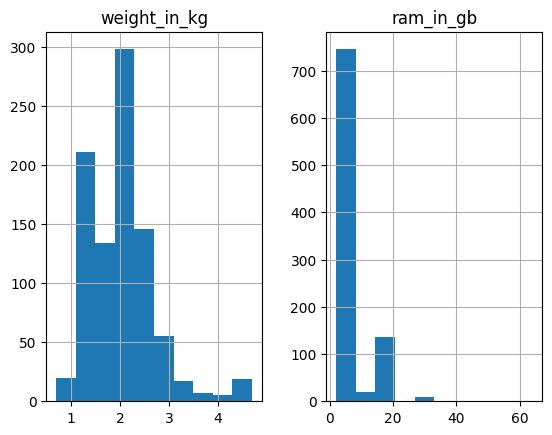

In [19]:
features_num_2=['weight_in_kg', 'ram_in_gb']
df[features_num_2].hist()

array([[<Axes: title={'center': 'weight_in_kg'}>,
        <Axes: title={'center': 'ram_in_gb'}>,
        <Axes: title={'center': 'ips_screen'}>,
        <Axes: title={'center': 'inches'}>,
        <Axes: title={'center': 'storage_ssd'}>],
       [<Axes: title={'center': 'typename_Gaming'}>,
        <Axes: title={'center': 'typename_Netbook'}>,
        <Axes: title={'center': 'typename_Notebook'}>,
        <Axes: title={'center': 'typename_Ultrabook'}>,
        <Axes: title={'center': 'typename_Workstation'}>],
       [<Axes: title={'center': 'opsys_Chrome OS'}>,
        <Axes: title={'center': 'opsys_Linux'}>,
        <Axes: title={'center': 'opsys_Mac OS X'}>,
        <Axes: title={'center': 'opsys_No OS'}>,
        <Axes: title={'center': 'opsys_Windows 10'}>],
       [<Axes: title={'center': 'opsys_Windows 10 S'}>,
        <Axes: title={'center': 'opsys_Windows 7'}>,
        <Axes: title={'center': 'opsys_macOS'}>,
        <Axes: title={'center': 'full_hd'}>,
        <Axes: title={'

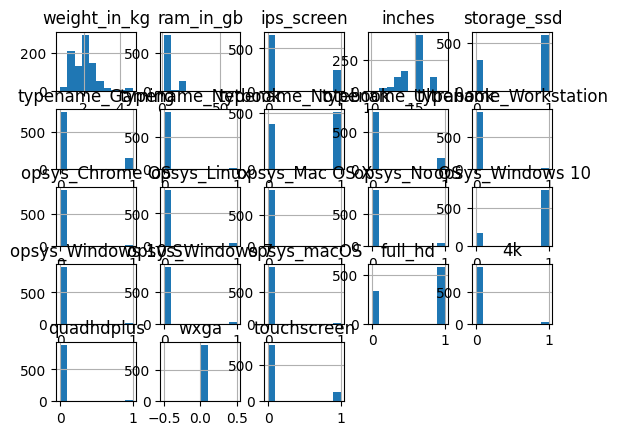

In [20]:
df[features_num].hist()

In [21]:


df_corr = df.corr(numeric_only= True)
print(df_corr['price_in_euros'])


inches                  0.071043
price_in_euros          1.000000
weight_in_kg            0.197086
ram_in_gb               0.738922
typename_Gaming         0.369605
typename_Netbook       -0.127296
typename_Notebook      -0.563899
typename_Ultrabook      0.274430
typename_Workstation    0.244388
opsys_Chrome OS        -0.139748
opsys_Linux            -0.173723
opsys_Mac OS X          0.019087
opsys_No OS            -0.167931
opsys_Windows 10        0.151139
opsys_Windows 10 S      0.025961
opsys_Windows 7         0.150640
opsys_macOS             0.092307
ips_screen              0.267188
storage_ssd             0.516708
full_hd                 0.238000
4k                      0.285960
quadhdplus              0.091936
wxga                         NaN
touchscreen             0.218089
Name: price_in_euros, dtype: float64


In [22]:
features_20240223=['weight_in_kg',
                   'ram_in_gb',
                   'typename_Gaming',
                   'typename_Netbook',
                   'typename_Notebook',
                   'typename_Ultrabook',
                   'typename_Workstation',
                   'ips_screen',
                   'storage_ssd',
                   'full_hd',
                   '4k',
                   'opsys_No OS',
                   'opsys_Windows 7',
                   'opsys_Chrome OS',
                   'opsys_Windows 10',
                   'opsys_macOS',
                   'touchscreen',
                   'inches']

-----------------------------------------------------------------------------------------------------------------

## Modelado

### 1. Definir X e y

In [23]:
#X = df.drop(['Price_in_euros'], axis=1).copy()
#y = df['Price_in_euros'].copy()
#previously I changed to lowercase all column names
X = df.drop(['price_in_euros'], axis=1).copy()
y = df['price_in_euros'].copy()
X.shape

(912, 29)

In [24]:
y.shape

(912,)

### 2. Dividir X_train, X_test, y_train, y_test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [26]:
'''
for col in features_num:
    bt.plot_grouped_histograms(df, cat_col= 'price_in_euros', num_col= col, group_size= df['price_in_euros'].nunique())
'''

"\nfor col in features_num:\n    bt.plot_grouped_histograms(df, cat_col= 'price_in_euros', num_col= col, group_size= df['price_in_euros'].nunique())\n"

In [27]:
corr = X.corr(numeric_only= True)
corr

,inches,weight_in_kg,ram_in_gb,typename_Gaming,typename_Netbook,typename_Notebook,typename_Ultrabook,typename_Workstation,opsys_Chrome OS,opsys_Linux,...,opsys_Windows 10 S,opsys_Windows 7,opsys_macOS,ips_screen,storage_ssd,full_hd,4k,quadhdplus,wxga,touchscreen
inches,1.000000,0.836236,0.226420,0.413787,-0.329073,0.234454,-0.421596,0.108807,-0.271712,0.094330,...,-0.102993,-0.049899,-0.118203,-0.086472,-0.047493,0.215787,-0.041392,-0.179785,NaN,-0.356602
weight_in_kg,0.836236,1.000000,0.359798,0.589687,-0.156425,0.037476,-0.447904,0.099524,-0.157746,0.056532,...,-0.096011,-0.032896,-0.109741,0.038646,-0.024872,0.185928,-0.003075,-0.175490,NaN,-0.290321
ram_in_gb,0.226420,0.359798,1.000000,0.460747,-0.126378,-0.410736,0.094377,0.051581,-0.114549,-0.101902,...,-0.014558,-0.044162,0.026109,0.201559,0.401194,0.224725,0.262863,0.090582,NaN,0.151001
typename_Gaming,0.413787,0.589687,0.460747,1.000000,-0.062901,-0.484631,-0.184411,-0.064571,-0.070893,-0.088136,...,-0.037925,-0.078149,-0.047647,0.166391,0.207531,0.284791,0.034849,-0.066203,NaN,-0.150816
typename_Netbook,-0.329073,-0.156425,-0.126378,-0.062901,1.000000,-0.163930,-0.062378,-0.021842,0.359701,-0.034381,...,0.075138,0.017319,-0.016117,-0.055507,-0.083823,-0.159583,-0.024987,-0.022393,NaN,-0.059739
typename_Notebook,0.234454,0.037476,-0.410736,-0.484631,-0.163930,1.000000,-0.480605,-0.168282,-0.074412,0.180065,...,-0.073540,-0.040083,-0.124177,-0.306933,-0.357814,-0.142128,-0.126184,-0.143093,NaN,-0.372139
typename_Ultrabook,-0.421596,-0.447904,0.094377,-0.184411,-0.062378,-0.480605,1.000000,-0.064035,-0.032410,-0.073632,...,0.136152,0.043498,0.258376,0.109971,0.235877,-0.045344,0.072538,0.156782,NaN,0.127524
typename_Workstation,0.108807,0.099524,0.051581,-0.064571,-0.021842,-0.168282,-0.064035,1.000000,-0.024617,-0.035294,...,-0.013169,0.271551,-0.016545,0.075361,0.048887,0.098565,0.019337,-0.022988,NaN,-0.039979
opsys_Chrome OS,-0.271712,-0.157746,-0.114549,-0.070893,0.359701,-0.074412,-0.032410,-0.024617,1.000000,-0.038749,...,-0.014459,-0.029793,-0.018165,-0.039957,-0.135124,-0.187338,-0.028162,0.020431,NaN,0.069386
opsys_Linux,0.094330,0.056532,-0.101902,-0.088136,-0.034381,0.180065,-0.073632,-0.035294,-0.038749,1.000000,...,-0.020729,-0.042715,-0.026043,-0.145245,-0.162971,-0.085241,-0.040377,-0.003446,NaN,-0.082532


In [28]:
X.columns

Index(['company', 'product', 'inches', 'screenresolution', 'cpu', 'memory',
       'gpu', 'weight_in_kg', 'ram_in_gb', 'typename_Gaming',
       'typename_Netbook', 'typename_Notebook', 'typename_Ultrabook',
       'typename_Workstation', 'opsys_Chrome OS', 'opsys_Linux',
       'opsys_Mac OS X', 'opsys_No OS', 'opsys_Windows 10',
       'opsys_Windows 10 S', 'opsys_Windows 7', 'opsys_macOS', 'ips_screen',
       'storage_ssd', 'full_hd', '4k', 'quadhdplus', 'wxga', 'touchscreen'],
      dtype='object')

features_20240223=['weight_in_kg',
                   'ram_in_gb',
                   'typename_Gaming',
                   'typename_Netbook',
                   'typename_Notebook',
                   'typename_Ultrabook',
                   'typename_Workstation',
                   'opsys_Chrome OS',
                   'opsys_Windows 10',
                   'opsys_Windows 10 S',
                   'opsys_macOS',
                   'quadhdplus',
                   'touchscreen']

In [29]:
X_train=X_train[features_20240223]
X_test=X_test[features_20240223]

In [30]:
y_train

1118    2899.00
153     1249.26
275     1958.90
1100    1030.99
131     1396.00
         ...   
578      389.00
996      549.00
770     1859.00
407      306.00
418     1943.00
Name: price_in_euros, Length: 729, dtype: float64

In [31]:
y_test

451     1099.00
802      959.00
723      857.07
682      699.00
1306     369.00
         ...   
369      639.00
626      379.00
416      304.45
546      859.00
260      949.00
Name: price_in_euros, Length: 183, dtype: float64

### 3. Baseline de modelos


In [32]:
rfr_model = RandomForestRegressor(random_state=42)
lr_model = LinearRegression()
dtr_model = DecisionTreeRegressor(random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)
knr_model=KNeighborsRegressor()
xgb_model=XGBRegressor(random_state=42)
lgb_model=LGBMRegressor(random_state=42,verbose=-100)
cbr_model=CatBoostRegressor(random_state=42,verbose=False)
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor

models={'RandomForestRegressor':rfr_model,
        'LinearRegression':lr_model,
        'DecisionTreeRegressor':dtr_model,
        'GradientBoostingRegressor':gbr_model,
        'KNeighborsRegressor':knr_model,
        'XGBRegressor':xgb_model,
        'LGBMRegressor':lgb_model,
        'CatBoostRegressor':cbr_model
        }

param_grid={'RandomForestRegressor':{
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
},
        'LinearRegression':{},
        'DecisionTreeRegressor':{},
        'GradientBoostingRegressor':{},
        'KNeighborsRegressor':{},
        'XGBRegressor':{},
        'LGBMRegressor':{},
        'CatBoostRegressor':{
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [100, 500, 1000],
    'random_strength': [0.5, 1, 1.5],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0.8, 1.0, 1.2]
}}

for key,value in models.items():
        if key=='LinearRegression':
                X_train_scaled,X_test_scaled=scaler_of_x_train_and_x_test(X_train,X_test,False)
        else:
                X_train_scaled=X_train
                X_test_scaled=X_test
        value.fit(X_train_scaled,y_train)
        y_pred =value.predict(X_test_scaled)
        MSE=mean_squared_error(y_test,y_pred)
        print(f"Modelo {key} tiene un MSE de :{MSE}")


Modelo RandomForestRegressor tiene un MSE de :167213.9175134146
Modelo LinearRegression tiene un MSE de :169737.5488811332
Modelo DecisionTreeRegressor tiene un MSE de :325710.1259302774
Modelo GradientBoostingRegressor tiene un MSE de :155496.77496994988
Modelo KNeighborsRegressor tiene un MSE de :189074.18937831695
Modelo XGBRegressor tiene un MSE de :195540.7107338724
Modelo LGBMRegressor tiene un MSE de :136156.47982312404
Modelo CatBoostRegressor tiene un MSE de :103903.76060652162


'''
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
'''

param_grid= {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [100, 500, 1000],
    'random_strength': [0.5, 1, 1.5],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0.8, 1.0, 1.2]
}

grid_search = GridSearchCV(estimator=cbr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
X_train_scaled=X_train
X_test_scaled=X_test
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters for GridSearchCV:", best_params)
y_pred =grid_search.predict(X_test_scaled)
MSE=mean_squared_error(y_test,y_pred)
print(f"Modelo grid_search tiene un MSE de :{MSE}")

param_grid= {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [100, 500, 1000],
    'random_strength': [0.5, 1, 1.5],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0.8, 1.0, 1.2]
}

random_search = RandomizedSearchCV(estimator=cbr_model,  param_distributions=param_grid, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42)
X_train_scaled=X_train
X_test_scaled=X_test
random_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Hyperparameters for RandomizedSearchCV:", best_params)
y_pred =random_search.predict(X_test_scaled)
MSE=mean_squared_error(y_test,y_pred)
print(f"Modelo RandomizedSearchCV tiene un MSE de :{MSE}")

param_grid = {
    'iterations': [100, 200, 300],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage during optimization
    'depth': [5, 7, 9],  # Depth of each tree
    'l2_leaf_reg': [1, 3, 5],  # L2 regularization term on weights
}

grid_search = GridSearchCV(estimator=cbr_model,  param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
X_train_scaled=X_train
X_test_scaled=X_test
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters for RandomizedSearchCV:", best_params)
y_pred =random_search.predict(X_test_scaled)
MSE=mean_squared_error(y_test,y_pred)
print(f"Modelo GridSearchCV tiene un MSE de :{MSE}")

RandomForestRegressor:

n_estimators: Number of trees in the forest. Increasing it generally improves performance until it starts overfitting.

max_depth: Maximum depth of the trees. Tune to control overfitting.

min_samples_split: Minimum number of samples required to split an internal node. Adjust for fine-tuning.

LinearRegression:

No significant hyperparameters to tune. Linear regression is a simple model.

DecisionTreeRegressor:

max_depth: Maximum depth of the tree. Controls overfitting.

min_samples_split: Minimum number of samples required to split an internal node. Adjust for fine-tuning.

GradientBoostingRegressor:

n_estimators: Number of boosting stages to be run. Higher values may lead to overfitting.

learning_rate: Controls the contribution of each tree. Lower values require more trees.

max_depth: Maximum depth of the individual trees. Tune for overfitting control.

KNeighborsRegressor:

n_neighbors: Number of neighbors to consider. Should be tuned based on the dataset.

XGBRegressor:

n_estimators: Number of boosting rounds. Higher values may lead to overfitting.

learning_rate: Step size shrinkage.

max_depth: Maximum depth of the trees. Controls overfitting.

LGBMRegressor:

n_estimators: Number of boosting rounds.

learning_rate: Step size shrinkage.

max_depth: Maximum depth of the trees.

num_leaves: Number of leaves in one tree.

CatBoostRegressor:

iterations: Number of boosting iterations.

learning_rate: Step size shrinkage.

depth: Depth of the trees.

l2_leaf_reg: L2 regularization term.


Modelo RandomForestRegressor tiene un MSE de :243404.9673903571
Modelo LinearRegression tiene un MSE de :266646.68655856466
Modelo DecisionTreeRegressor tiene un MSE de :339157.2134945974
Modelo GradientBoostingRegressor tiene un MSE de :276888.1169838697
Modelo KNeighborsRegressor tiene un MSE de :210994.92781503825

Modelo RandomForestRegressor tiene un MSE de :1332412.5962730162
Modelo LinearRegression tiene un MSE de :1081538.271481829

'''
rfr_reg = RandomForestRegressor()
lr_reg = LinearRegression()

models={'RandomForestRegressor':rfr_reg,
        'LinearRegression':lr_reg
        }

for key,value in models.items():

        value.fit(scaler_of_x_train(X_train,False),y_train)
        y_pred =value.predict(scaler_of_x_train(X_test,False))
        MSE=mean_squared_error(y_test,y_pred)
        print(f"Modelo {key} tiene un MSE de :{MSE}")
'''        

In [33]:
y_pred.shape

(183,)

### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de RMSE.

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [34]:
X_pred = pd.read_csv("data/test.csv",index_col=0)
X_pred.index.name=None
X_pred.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg


In [35]:
X_pred.shape

(391, 11)

In [36]:
features_num

['weight_in_kg',
 'ram_in_gb',
 'ips_screen',
 'inches',
 'storage_ssd',
 'typename_Gaming',
 'typename_Netbook',
 'typename_Notebook',
 'typename_Ultrabook',
 'typename_Workstation',
 'opsys_Chrome OS',
 'opsys_Linux',
 'opsys_Mac OS X',
 'opsys_No OS',
 'opsys_Windows 10',
 'opsys_Windows 10 S',
 'opsys_Windows 7',
 'opsys_macOS',
 'full_hd',
 '4k',
 'quadhdplus',
 'wxga',
 'touchscreen']

In [37]:
X_pred['weight_in_kg']= X_pred['Weight'].str.replace('kg', '').astype(float)
X_pred['ram_in_gb'] = X_pred['Ram'].str.replace('GB', '').astype(float)
X_pred.drop(columns={'Weight','Ram'},inplace=True)
#change all column names to lowercase for avoiding typos
keys=X_pred.columns.to_list()
new_columns={}
for column in keys:
    value=column.lower()
    new_columns[column]=value
print(new_columns)
X_pred.rename(columns=new_columns,inplace=True)
X_pred.columns.to_list()



{'Company': 'company', 'Product': 'product', 'TypeName': 'typename', 'Inches': 'inches', 'ScreenResolution': 'screenresolution', 'Cpu': 'cpu', 'Memory': 'memory', 'Gpu': 'gpu', 'OpSys': 'opsys', 'weight_in_kg': 'weight_in_kg', 'ram_in_gb': 'ram_in_gb'}


['company',
 'product',
 'typename',
 'inches',
 'screenresolution',
 'cpu',
 'memory',
 'gpu',
 'opsys',
 'weight_in_kg',
 'ram_in_gb']

In [38]:
X_pred["ips_screen"]=0
indices=[]
for indice,valor in X_pred.iterrows():
    if "IPS" in valor["screenresolution"]:
        indices.append(indice)
X_pred.loc[indices, 'ips_screen'] = 1

print(X_pred.columns.to_list())
X_pred["storage_ssd"]=0
indices=[]
for indice,valor in X_pred.iterrows():
    print(valor["memory"].lower())
    if "ssd" in valor["memory"].lower():
        indices.append(indice)
        print(indice)
X_pred.loc[indices, 'storage_ssd'] = 1
X_pred.rename(columns=new_columns,inplace=True)
onehot = OneHotEncoder(sparse_output=False, drop='first') 
data = onehot.fit_transform(X_pred[features_cat_2])
new_features = onehot.get_feature_names_out()
X_pred[new_features] = data
X_pred.drop(columns= features_cat_2, axis = 1, inplace = True)
X_pred["full_hd"]=0.0
indices=[]
for indice,valor in X_pred.iterrows():
    #print(valor["memory"].lower())
    if "1920x1080" in valor["screenresolution"].lower():
        indices.append(indice)
        print(indice)
X_pred.loc[indices, 'full_hd'] = 1.0
X_pred["4k"]=0
indices=[]
for indice,valor in X_pred.iterrows():
    #print(valor["memory"].lower())
    if "3840x2160" in valor["screenresolution"].lower():
        indices.append(indice)
        print(indice)
X_pred.loc[indices, '4k'] = 1.0
X_pred["quadhdplus"]=0.0
indices=[]
for indice,valor in X_pred.iterrows():
    #print(valor["memory"].lower())
    if "3200x1800" in valor["screenresolution"].lower():
        indices.append(indice)
        print(indice)
X_pred.loc[indices, 'quadhdplus'] = 1.0
X_pred["wxga"]=0.0
indices=[]
for indice,valor in X_pred.iterrows():
    #print(valor["memory"].lower())
    if "1336x768" in valor["screenresolution"].lower():
        indices.append(indice)
        print(indice)
X_pred.loc[indices, 'wxga'] = 1.0

X_pred["touchscreen"]=0.0
indices=[]
for indice,valor in X_pred.iterrows():
    #print(valor["memory"].lower())
    if "touchscreen" in valor["screenresolution"].lower():
        indices.append(indice)
        print(indice)
X_pred.loc[indices, 'touchscreen'] = 1.0


['company', 'product', 'typename', 'inches', 'screenresolution', 'cpu', 'memory', 'gpu', 'opsys', 'weight_in_kg', 'ram_in_gb', 'ips_screen']
512gb ssd
209
500gb hdd
1tb hdd
256gb ssd
1231
256gb ssd
1020
128gb ssd
379
500gb hdd
256gb ssd
172
256gb ssd
779
32gb flash storage
256gb ssd +  1tb hdd
256
256gb ssd
117
1tb hdd
512gb ssd
1195
500gb hdd
1tb hdd
512gb ssd
715
256gb ssd
160
256gb ssd
1021
256gb ssd
49
128gb ssd +  1tb hdd
690
32gb flash storage
1tb hdd
512gb ssd
857
1tb hdd
1tb hdd
1tb hdd
32gb flash storage
512gb ssd +  1tb hdd
953
256gb ssd
460
256gb ssd +  1tb hdd
1092
1tb hdd
128gb ssd
806
256gb ssd +  1tb hdd
986
512gb ssd
917
256gb ssd +  1tb hdd
408
1tb hdd
512gb ssd +  1tb hdd
959
128gb ssd +  1tb hdd
461
256gb ssd
858
1tb hdd
512gb ssd
1293
1.0tb hybrid
256gb ssd
628
1tb hdd
128gb ssd +  1tb hdd
933
256gb ssd
676
500gb hdd
256gb ssd
125
128gb ssd
450
512gb ssd
67
1tb hdd
128gb ssd +  1tb hdd
769
500gb hdd
256gb ssd
1162
256gb ssd
594
256gb ssd
288
1tb hdd
1tb hdd
2tb hdd


for key,value in models.items():
        if key=='LinearRegression':
                X_train_scaled,X_test_scaled=scaler_of_x_train_and_x_test(X_pred[features_num],X_test,False)
        else:
                X_train_scaled=X_train
                X_test_scaled=X_test
        value.fit(X_train_scaled,y_train)
        y_pred =value.predict(X_test_scaled)
        MSE=mean_squared_error(y_test,y_pred)
        print(f"Modelo {key} tiene un MSE de :{MSE}")


In [39]:
X_test

,weight_in_kg,ram_in_gb,typename_Gaming,typename_Netbook,typename_Notebook,typename_Ultrabook,typename_Workstation,ips_screen,storage_ssd,full_hd,4k,opsys_No OS,opsys_Windows 7,opsys_Chrome OS,opsys_Windows 10,opsys_macOS,touchscreen,inches
451,2.20,8.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,15.6
802,2.08,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,1.0,15.6
723,1.87,8.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,14.0
682,1.63,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,1.0,14.0
1306,2.20,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,15.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1.86,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,15.6
626,1.25,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,11.6
416,1.15,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,11.6
546,1.87,8.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,14.0


In [40]:
X_pred

,company,product,inches,screenresolution,cpu,memory,gpu,weight_in_kg,ram_in_gb,ips_screen,...,opsys_No OS,opsys_Windows 10,opsys_Windows 10 S,opsys_Windows 7,opsys_macOS,full_hd,4k,quadhdplus,wxga,touchscreen
209,Lenovo,Legion Y520-15IKBN,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,512GB SSD,Nvidia GeForce GTX 1060,2.400,16.0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
1281,Acer,Aspire ES1-531,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,500GB HDD,Intel HD Graphics 400,2.400,4.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,15.6,1366x768,Intel Core i3 6006U 2.0GHz,1TB HDD,Intel HD Graphics 520,1.900,4.0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
1231,Dell,Inspiron 7579,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,256GB SSD,Intel HD Graphics 620,2.191,8.0,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,1.0
1020,HP,ProBook 640,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,256GB SSD,Intel HD Graphics 620,1.950,4.0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,MSI,GE72MVR 7RG,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,2.900,16.0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
948,Toshiba,Tecra Z40-C-12X,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,128GB SSD,Intel HD Graphics 520,1.470,4.0,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
483,Dell,Precision M5520,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,256GB SSD,Nvidia Quadro M1200,1.780,8.0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0
1017,HP,Probook 440,14.0,1366x768,Intel Core i5 7200U 2.5GHz,500GB HDD,Intel HD Graphics 620,1.640,4.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0


In [41]:
#'estoy aquí, meter columnas que no existen a 0
for feature in features_num:
        if feature not in X_pred.columns.tolist():
                X_pred[feature]=0.0



In [42]:
X_pred=X_pred[features_20240223]
for key,value in models.items():
        if key=='LinearRegression':
                X_train_scaled,X_test_scaled=scaler_of_x_train_and_x_test(X_pred,X_test,False)
        else:
                X_train_scaled=X_pred
                X_test_scaled=X_test
        #value.fit(X_train_scaled,y_train)
        y_pred =value.predict(X_test_scaled)
        MSE=mean_squared_error(y_test,y_pred)
        print(f"Modelo {key} tiene un MSE de :{MSE}")

Modelo RandomForestRegressor tiene un MSE de :167213.9175134146
Modelo LinearRegression tiene un MSE de :171709.28868679306
Modelo DecisionTreeRegressor tiene un MSE de :325710.1259302774
Modelo GradientBoostingRegressor tiene un MSE de :155496.77496994988
Modelo KNeighborsRegressor tiene un MSE de :189074.18937831695
Modelo XGBRegressor tiene un MSE de :195540.7107338724
Modelo LGBMRegressor tiene un MSE de :136156.47982312404
Modelo CatBoostRegressor tiene un MSE de :103903.76060652162


X_pred["ips_screen"]=0
indices=[]
for indice,valor in X_pred.iterrows():
    if valor["screenresolution"].find("IPS"):
        indices.append(indice)

X_pred.loc[indices, 'ips_screen'] = 1
print(features_num)
print(features_cat)
print(X_pred.columns.to_list())

X_pred=X_pred[features_num]

In [43]:
print(X_test.columns.to_list(),X_test.shape)
print(X_pred.columns.to_list(),X_pred.shape)

['weight_in_kg', 'ram_in_gb', 'typename_Gaming', 'typename_Netbook', 'typename_Notebook', 'typename_Ultrabook', 'typename_Workstation', 'ips_screen', 'storage_ssd', 'full_hd', '4k', 'opsys_No OS', 'opsys_Windows 7', 'opsys_Chrome OS', 'opsys_Windows 10', 'opsys_macOS', 'touchscreen', 'inches'] (183, 18)
['weight_in_kg', 'ram_in_gb', 'typename_Gaming', 'typename_Netbook', 'typename_Notebook', 'typename_Ultrabook', 'typename_Workstation', 'ips_screen', 'storage_ssd', 'full_hd', '4k', 'opsys_No OS', 'opsys_Windows 7', 'opsys_Chrome OS', 'opsys_Windows 10', 'opsys_macOS', 'touchscreen', 'inches'] (391, 18)


for key,value in models.items():
        X_train_scaled,X_test_scaled=scaler_of_x_train_and_x_test(X_train,X_pred[features_num],True)
        value.fit(X_train_scaled,y_train)
        predictions_submit =value.predict(X_pred[features_num])
        MSE=mean_squared_error(y_test,predictions_submit)
        print(f"Modelo {key} tiene un MSE de :{MSE}")


X_train_scaled,X_pred_scaled=scaler_of_x_train_and_x_test(X_train,X_pred[features_num],True)


In [44]:
predictions_submit = cbr_model.predict(X_pred[features_20240223])
predictions_submit
predictions_submit= rfr_model.predict(X_pred[features_20240223])
predictions_submit
predictions_submit=lgb_model.predict(X_pred[features_20240223])
predictions_submit
predictions_submit=xgb_model.predict(X_pred[features_20240223])
predictions_submit

array([1266.8439 ,  329.48477,  367.74194, 1232.5192 ,  916.92334,
        450.60184,  641.22614, 1161.1505 , 1472.6348 ,  590.6117 ,
       2409.962  ,  787.992  ,  490.52768, 1479.5532 ,  801.0004 ,
        481.64487, 2845.1362 , 1431.759  , 1757.8744 ,  720.24475,
       1658.9337 ,  468.21814,  537.51514, 1383.429  ,  384.30527,
        714.06354,  573.3286 ,  636.19086, 2525.2407 , 1042.0986 ,
       2314.996  ,  445.8658 ,  830.92377, 3444.21   , 2207.5718 ,
       2006.5183 ,  575.32416, 1350.3474 ,  977.192  , 1752.5393 ,
        794.46735,  765.8314 ,  577.17316, 1138.8906 , 1923.8612 ,
       1139.54   , 1180.7433 ,  445.8658 ,  598.724  ,  548.8159 ,
       1840.5729 ,  714.06354, 1150.0009 ,  211.21808, 1927.5598 ,
       1740.9977 ,  556.70514,  858.15625, 1113.6656 ,  704.5424 ,
       2448.6494 , 2456.452  ,  526.70984, 2105.44   ,  979.6598 ,
       1106.9264 ,  678.87726, 1436.9297 , 2008.3818 , 1738.5663 ,
        767.8091 ,  723.42975,  847.17377, 1824.658  , 1020.47

In [45]:
predictions_submit.shape

(391,)

**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [46]:
# ¿Qué opináis?
# ¿Sí, no?

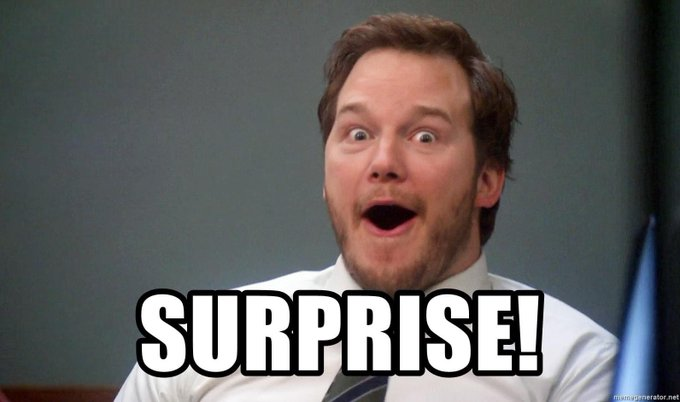

### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [47]:
sample = pd.read_csv("data/sample_submission.csv")

In [48]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [49]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [50]:
submission = pd.DataFrame({"laptop_ID": X_pred.index, "Price_in_euros": predictions_submit})

In [51]:
submission.head()

,laptop_ID,Price_in_euros
0,209,1266.843872
1,1281,329.484772
2,1168,367.741943
3,1231,1232.519165
4,1020,916.923340


In [52]:
submission.shape

(391, 2)

### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [53]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Iván y Manuel: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `laptops_test.csv`. Lloramos.")

In [54]:
chequeador(submission)

You're ready to submit!
